<a href="https://colab.research.google.com/github/rafaeldjsm/Datacamp_Projects/blob/main/Product_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of New Product Sales Methods

* The ‘Pens and Printers’ company is planning to launch a new product line and needs insights into effective sales strategies.
* The primary goal of this analysis is to enable a successful launch by identifying the most effective techniques for selling the new product, given the high costs associated with introducing a new product line.
* Key variables and metrics will be analyzed to determine the success of various sales strategies.
* Sales Performance Analysis: The effectiveness of different sales strategies will be assessed based on these variables and metrics.
* A metric for the business to monitor will be defined.
* Based on the analysis, recommendations for improving sales strategies will be provided.

**The main questions to be answered are:**
* **- What does the spread of the revenue look like overall? And for each method?**
* **- Was there any difference in revenue over time for each of the methods?**
* **- Based on the data, which method would you recommend we continue to use?**


**About Pens and Printers**

Pens and Printers was founded in 1984 and provides high quality office products to large
organizations. We are a trusted provider of everything from pens and notebooks to desk
chairs and monitors. We don’t produce our own products but sell those made by other
companies.
We have built long lasting relationships with our customers and they trust us to provide them
with the best products for them. As the way in which consumers buy products is changing,
our sales tactics have to change too. Launching a new product line is expensive and we need
to make sure we are using the best techniques to sell the new product effectively. The best
approach may vary for each new product so we need to learn quickly what works and what
doesn’t.


**DESCRIPTION OF THE CHARACTERISTICS AND DEMANDS OF EACH SALES METHOD**

| Method | Description | Time required |
| --- | --- | --- |
| Email | Customers in this group received an email when the product line <br />was launched, and a further email three weeks later. | **Very little** work for the team. |
| Call | Customers in this group were called by a member of the sales team. | On average **30 minutes** per customer. |
| Email and call | Customers in this group were first sent the product information email,<br /> then called a **week later** by the sales team to talk about their needs and <br />how this new product may support their work. | The email required little work from the team, <br />the call was around **10 minutes per customer.** |

# 1. Requirements

In [1]:
#@title
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd
from statsmodels.formula.api import ols
import missingno as msno
import geopandas as gpd

plt.style.use('seaborn-v0_8-colorblind')

# Import Datasets
## Product Sales Dataset
df = pd.read_csv("https://s3.amazonaws.com/talent-assets.datacamp.com/product_sales.csv")

## Population USA 2020
# https://www2.census.gov/programs-surveys/decennial/2020/data/apportionment/apportionment-2020-table01.xlsx
dfpop = pd.read_excel("https://www2.census.gov/programs-surveys/decennial/2020/data/apportionment/apportionment-2020-table01.xlsx",
    skiprows = 3,
    usecols=[0,1],
    names=['state','population'])

## Geospacial USA dataset
# https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json
dfgeo = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")

# Functions
# Forward stepwise feature selection

def r2_adj(variables, target, basetable):

    formula = "{} ~ {}".format(target,' + '.join(variables))

    return ols(formula, basetable).fit().rsquared_adj

def next_best(current_variables,candidate_variables, target, basetable):
    best_r2_adj = -1
    best_variable = None
    for v in candidate_variables:
        r2_adj_v = r2_adj(current_variables + [v], target, basetable)
        if r2_adj_v >= best_r2_adj:
            best_r2_adj = r2_adj_v
            best_variable = v
    return best_variable


def forward_stepwise(data = None,candidate_variables=None, target = 'revenue',n_iter = 4):
    '''
    forward stepwise feature selection
    n_iter : number of iterations
    '''
    # Initialize the current variables
    current_variables = []

    # The forward stepwise variable selection procedure
    for i in range(0, n_iter):
        next_variable = next_best(current_variables,candidate_variables, target, data)
        current_variables = current_variables + [next_variable]
        candidate_variables.remove(next_variable)
        print("Variable added in step " + str(i+1)  + " is " + next_variable + ".")
    print(current_variables)


## Bootstrap for hypothesis test

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data.
    """
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def boots_test(data1,data2,n_bootstraps = 10000):
    '''
    Perform a bootstrap hypothesis test to evaluate the hypothesis that the means of two methods are equal.
    The p-value is calculated as the proportion of bootstrap samples in which the difference in means is greater than or        equal to the observed difference in means.

    Parameters
    ----------
    data1 : array-like
        The first dataset to compare.
    data2 : array-like
        The second dataset to compare.
    mar2 : float
        Mean of data2
    mt : float
        Mean of concatenate data1 and data2
    n_bootstraps : int, optional
        The number of bootstrap samples to generate. Default is 10000.

    Returns
    -------
    p_value : float
        The p-value for the hypothesis test.
    '''

    data_concat = np.concatenate((data1,data2))
    mean_concat = np.mean(data_concat)

    mar1 = np.mean(data1)
    mar2 = np.mean(data2)

    diff_means_exp = mar1 - mar2

    # Generate shifted arrays
    data1_shifted = data1 - mar1 + mean_concat
    data2_shifted = data2 - mar2 + mean_concat

    # Compute 10,000 bootstrap replicates from shifted arrays
    bs_reps_1 = draw_bs_reps(data1_shifted,np.mean,n_bootstraps)
    bs_reps_2 = draw_bs_reps(data2_shifted,np.mean,n_bootstraps)

    # Get replicates of difference of means: bs_replicates
    bs_reps = bs_reps_1 - bs_reps_2

    # Compute and return p-value
    return np.sum(bs_reps >= diff_means_exp) / len(bs_reps)

# 2. Data validation:

Before cleaning and validation, the dataset contained **15,000 rows and 8 columns**. Each column was thoroughly validated against the criteria specified in the dataset table.

**DATA DESCRIPTION AND VALIDATION ADOPTED**

|Column Name | Details|Obs|
|------------|--------|--------|
| week | Week sale was made, counted as weeks since product launch | 6 unique values without missing values.No cleaning is needed |
| sales_method | Character, which of the **three** sales methods were used for that customer | This feature was expected to have only three methods, but it had five types of values ['Email', 'Email + Call', 'Call', 'em + call', 'email']. These values were adjusted  to three ['Email', 'Email + Call', 'Call'].|
| customer_id | Character, unique identifier for the customer |Only nique values without missing values.No cleaning is needed |
| nb_sold | Numeric, number of new products sold | 10 unique values without missing values.No cleaning is needed |
| revenue | Numeric, revenue from the sales, rounded to 2 decimal places. | The only feature with missing data, as **more than 5%** of the data was missing, **it was necessary to impute data** through linear regression. |
|years_as_customer | Numeric, number of years customer has been buying from us (company founded in 1984) |It was necessary to exclude two rows due to inconsistent data, as they indicated customers who had been consumers for more than 39 years |
| nb_site_visits | Numeric, number of times the customer has visited our website in the last 6 months |27 unique values without missing values.No cleaning is needed |
| state | Character, location of the customer i.e. where orders are shipped |50 unique values without missing values.No cleaning is needed |

## 2.1 Check info and dtypes

In [2]:
#@title
# View on DataFrame
print("Dataframe Summary Information\n")
df.info();

print("\nPreviewing the Dataframe")
display(df.head())

Dataframe Summary Information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB

Previewing the Dataframe


,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


## 2.2 Unique Values

**Checking the number of unique values of the features**

* There are three sales methods. How can there be 5 unique values?
* Pens and Printers’ was founded in 1984, so the company is 39 years old. How can there be 42 unique values in this column?

In [3]:
#@title
display(df.nunique().to_frame().rename(columns = {0:'Count'}))

# Adjusting the ‘sales_method’ feature to three categories
df['sales_method'] =  df['sales_method'].replace({'em + call':'Email + Call','email':'Email'})

,Count
week,6
sales_method,5
customer_id,15000
nb_sold,10
revenue,6743
years_as_customer,42
nb_site_visits,27
state,50


## 2.3 Descriptive statistics

**Check Descriptive statistics for identifying incomplete, or inconsistent data.**

### 2.3.1 Numeric Features

Pens and Printers’ was founded in 1984, it doesn’t make sense for there to be a customer who has been buying for more than 63 years.

In [4]:
#@title
df.describe().round(3)

,week,nb_sold,revenue,years_as_customer,nb_site_visits
count,15000.000,15000.000,13926.000,15000.000,15000.000
mean,3.098,10.085,93.935,4.966,24.991
std,1.656,1.812,47.435,5.045,3.501
min,1.000,7.000,32.540,0.000,12.000
25%,2.000,9.000,52.470,1.000,23.000
50%,3.000,10.000,89.500,3.000,25.000
75%,5.000,11.000,107.328,7.000,27.000
max,6.000,16.000,238.320,63.000,41.000


### 2.3.2 Categorical Features

* California is the state with the most customers
* E-mail was the most used method (So this required very little work for the team)
* customer_id contains only unique values

In [5]:
#@title
df.describe(include = 'object')

,sales_method,customer_id,state
count,15000,15000,15000
unique,3,15000,50
top,Email,2e72d641-95ac-497b-bbf8-4861764a7097,California
freq,7466,1,1872


## 2.4 Inputting of inconsistent data

There may have been some kind of mistake and the consumer is the oldest possible (39 years). In this specific case, we will discard these values for the continuation of this case. However, it would be interesting to check with the sales team to understand where this data came from and why these initial purchase dates are ‘incorrect.’ This would help the company understand what happened and prevent this error from occurring in the future.

In [6]:
#@title
display(df[df['years_as_customer'] > 39])

# drop inconsistent data
df.drop(df[df['years_as_customer'] > 39].index, inplace=True, axis = 0)

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,Email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,63,24,California
13800,4,Call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,47,27,California


## 2.5 Missing Values Analysis

**Check % from missing values and if there is any pattern in the missing values**

The only feature with missing data is revenue. Since the percentage of missing values is considerable, let’s examine this feature and consider alternatives for fixing or imputing the missing values.

Apparently, the missing data does not seem to follow a pattern or depend on other variables.

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,0.00%,0.00%,0.00%,0.00%,7.16%,0.00%,0.00%,0.00%


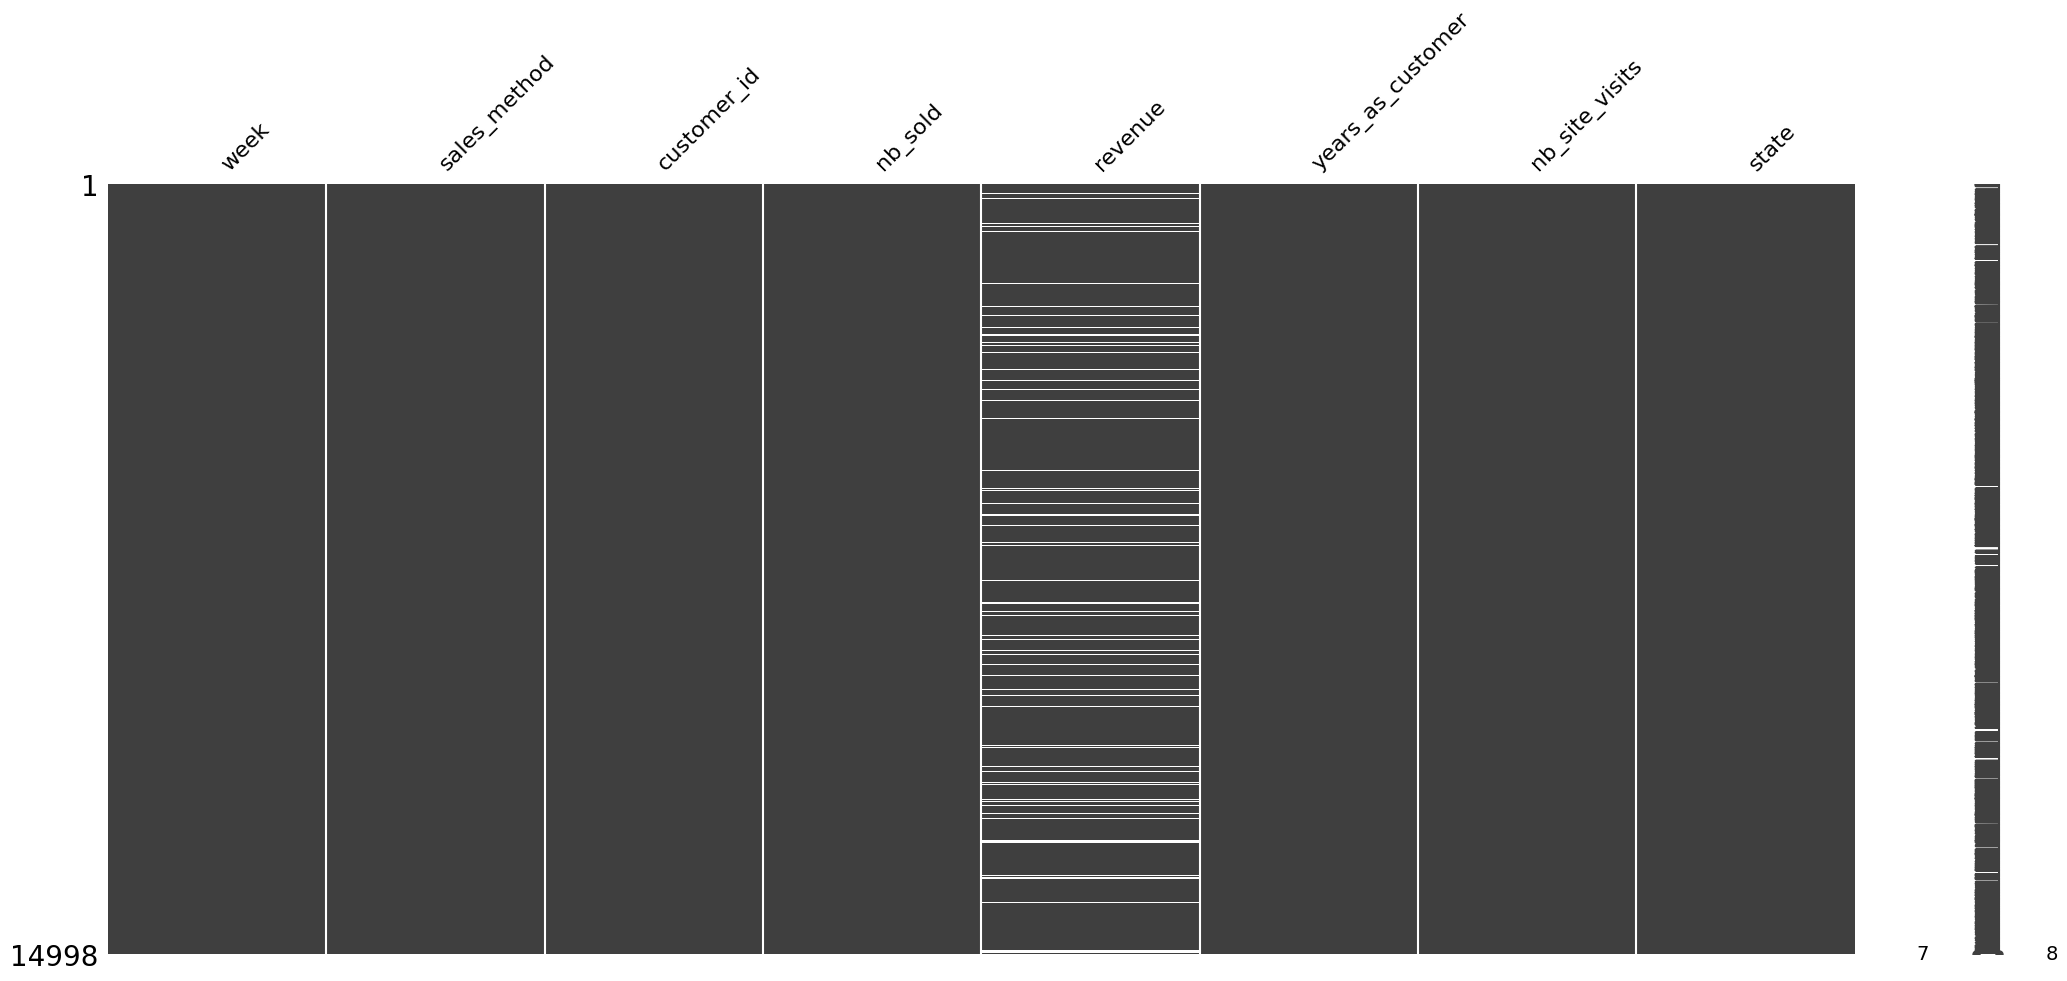

In [7]:
#@title
display(df.isna().mean().map('{:,.2%}'.format).to_frame().T)

msno.matrix(df)
plt.show()

## 2.6 Relationship between Missing Values and Other Features

**Let’s check for a possible relationship between the missing values and the data from the other features.**

Since the missing values are found only in the ‘`revenue`’ feature, let’s check which features have the most correlation with ‘`revenue`’ to study a possible imputation of the missing values

> * **Analysis of the correlations between features**

>> In this verification, we observed that the features with the highest correlation with revenue are **‘`sales_method`’, ‘`nb_sold`’, ‘`week`’ and '`nb_site_visits`'.**

> * **Feature Selection using Statistical Tests - Significance level < 5%**

>> As in the previous analysis, the features with the lowest level of significance were **‘`sales_method`’, ‘`nb_sold`’,‘`week`’ and '`nb_site_visits`'**.Since ‘state’ had a significance close to the chosen threshold, we will disregard it.

> * **Forward stepwise feature selection**

>> Since the previous methods indicated 4 (four) variables, we will use the ‘Forward stepwise feature selection’ method to verify the 4 (four) most relevant variables. As in the previous analyses, the features with the best performance were **‘`sales_method`’, ‘`nb_sold`’, ‘`week`’, and ‘`nb_site_visits`’**.

Variable added in step 1 is sales_method.
Variable added in step 2 is nb_sold.
Variable added in step 3 is week.
Variable added in step 4 is nb_site_visits.
['sales_method', 'nb_sold', 'week', 'nb_site_visits']


<ipython-input-8-982024aac55d>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, mask = abs(df.corr()) < 0.3, cmap = 'Blues')


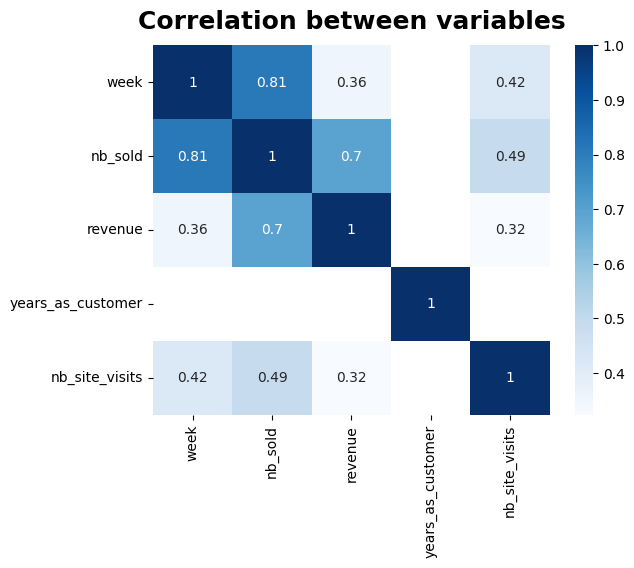

In [8]:
#@title
dfna = df[df['revenue'].isna()]

df_non_na = df[~df['revenue'].isna()]

# Find the candidate variables
candidate_variables = ['week', 'sales_method', 'nb_sold','years_as_customer', 'nb_site_visits', 'state']

forward_stepwise(data = df_non_na, candidate_variables = candidate_variables, target = 'revenue',n_iter = 4)

sns.heatmap(df.corr(), annot=True, mask = abs(df.corr()) < 0.3, cmap = 'Blues')
plt.title("Correlation between variables", fontsize= 18, fontweight = 800, pad = 12)
plt.show()

## 2.7 Data Imputation

**Missing data imputation with the linear regression**

An R² score (coefficient of determination) and adjusted R² around 98% is observed, showing that the other variables were able to explain 98% of the variance of the ‘revenue’ feature, a great metric for the action of imputing missing data.\
This observation is also very relevant, as it indicates that there is a very strong relationship between the revenue generated and the features **‘sales_method’, ‘nb_sold’, ‘week’, and ‘nb_site_visits**’.

In [9]:
#@title
# Create the model object
model = ols("revenue ~ week + sales_method + nb_sold + nb_site_visits", data = df).fit()

dfna['revenue'] = model.predict(dfna)

df = pd.concat([df_non_na,dfna])

print(f'R-squared:{model.rsquared:.4f}')
print(f'Adj. R-squared:{model.rsquared_adj:.4f}')

R-squared:0.9799
Adj. R-squared:0.9799


<ipython-input-9-526cc6000b54>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfna['revenue'] = model.predict(dfna)


### 2.7.1 Impact of Imputation

**Checking the impact of missing value imputation on the distribution of ‘revenue’.**

The predicted value of ‘`revenue`’ will now be imputed in the dataframe with missing values and concatenated to the dataframe without missing values. The distribution before and after data imputation will then be compared.\
It has been observed that the distribution after imputation remained similar to the distribution of non-missing values. This is a great indication that the imputation maintained the original distribution pattern of the dataset.

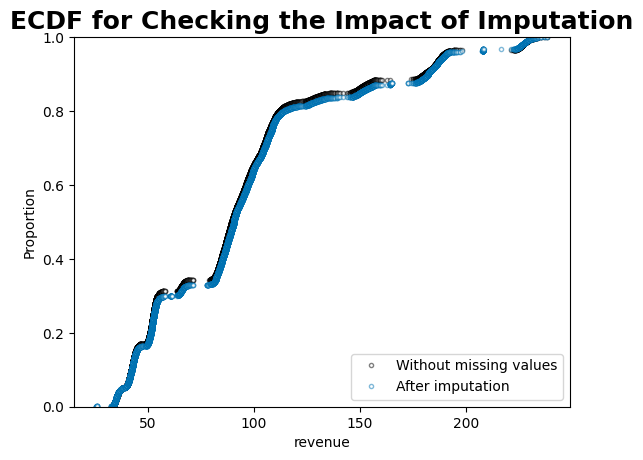

In [10]:
#@title
sns.ecdfplot(data=df_non_na,x="revenue",ls = 'none',color = 'w',marker = 'o',
             markersize = 3,markeredgecolor = 'k',alpha = 0.5,label = 'Without missing values')

sns.ecdfplot(data=df,x="revenue",ls = 'none',marker = 'o', color = 'w',
             markersize = 3,markeredgecolor = 'C0', alpha = 0.5,label = 'After imputation')

plt.title('ECDF for Checking the Impact of Imputation', fontsize= 18, fontweight = 800)
plt.legend(loc = 'lower right')
plt.show()

# 3. Sales Performance Analysis

## 3.1 Distribution of Customers by Method

**How many customers were there for each approach?**

Currently, the most commonly used sales method is `Email` (49.77%), followed by ‘`Call`’ and ‘`Email+Call`’ which represent 33.08% and 17.15% respectively.

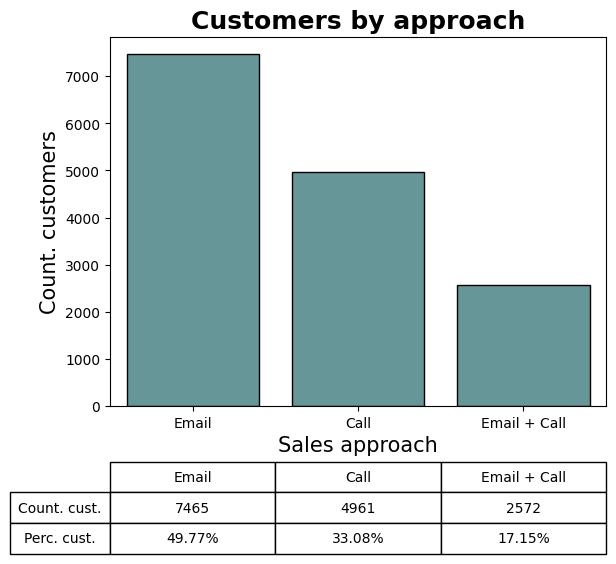

In [11]:
#@title
cnt_mthod = df['sales_method'].value_counts().to_frame()
cnt_mthod['perc'] = (cnt_mthod['sales_method'] / len(df)).apply('{:,.2%}'.format)
cnt_mthod = cnt_mthod.T

sns.countplot(x = 'sales_method',
              data = df,
              color = 'cadetblue',
              edgecolor = 'black',
              order = cnt_mthod.columns)

plt.table(cellText=cnt_mthod.values,
          rowLabels=['Count. cust.','Perc. cust.'],
          colLabels=cnt_mthod.columns,
          cellLoc = 'center', rowLoc = 'center',
          loc='right', bbox=[0,-0.4,1.0,.25])

plt.xlabel('Sales approach', fontsize= 15)
plt.ylabel('Count. customers', fontsize= 15)
plt.title("Customers by approach", fontsize= 18, fontweight = 800)
plt.show()

## 3.2 Revenue Distribution

**What does the spread of the revenue look like overall? And for each method?**

As there are multiple different products, the  revenue will vary depending on which products were sold, the distribution of revenue is multimodal (five-mode), possibly due to the presence of different types of product lines, which can acquire prices in the range of \$ 50, \$ 90, \$ 150, \$ 180 or \$ 230, as shown below

Mode nº = 0 $46.66
Mode nº = 1 $92.81
Mode nº = 2 $151.77
Mode nº = 3 $185.10
Mode nº = 4 $227.40
Revenue's Average $ 95.69


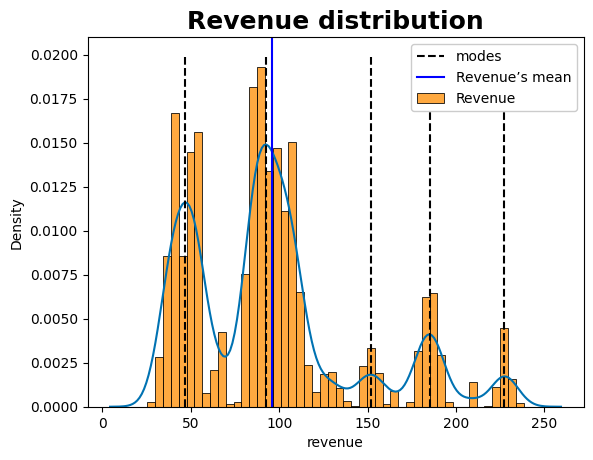

In [12]:
#@title
my_kde = sns.kdeplot(data=df, x='revenue')
lines = my_kde.lines[0]

x, y = lines.get_data()

arrmod = x[(np.diff(y, prepend=y[0]) > 0) & (np.diff(y[::-1], prepend=y[-1])[::-1] > 0)]

print('\n'.join([f'Mode nº = {cnt} ${k:.2f}' for cnt, k in enumerate(arrmod)]))

plt.vlines(arrmod,ymin=0,ymax=0.02, ls='--', color='black', label = 'modes')

sns.histplot(x = 'revenue',
            bins = 'auto',
            color = 'darkorange',
            stat = 'density',
            data = df,
            label = 'Revenue')

r_m = df['revenue'].mean()
print(f"Revenue's Average $ {r_m:.2f}")
plt.axvline(r_m, color = 'blue',label = "Revenue’s mean")

plt.legend(framealpha=1)
plt.title("Revenue distribution", fontsize= 18, fontweight = 800)
plt.show()

### 3.2.1 Revenue distribution for each approach.

**What does the spread of the revenue look like for each method?**

* In terms of `revenue` distribution, the ‘`Email+Call`’ approach is the best, followed by the ‘`Email`’ approach, while the ‘`Call`’ approach generates the least revenue.
* The ‘`Email+Call`’ approach also has the greatest dispersion.
* It is noted that the ‘`Call`’ approach, in addition to being the most time-consuming for the team, also generates the least revenue.
* The approach ‘`Email`’ that requires the least time from the team generates intermediate `revenue`.
* Meanwhile, the approach that combines the two previous approaches, ‘`Email+Call`’, has a time demand of **10 minutes** for a call and performs better in terms of generated revenue.

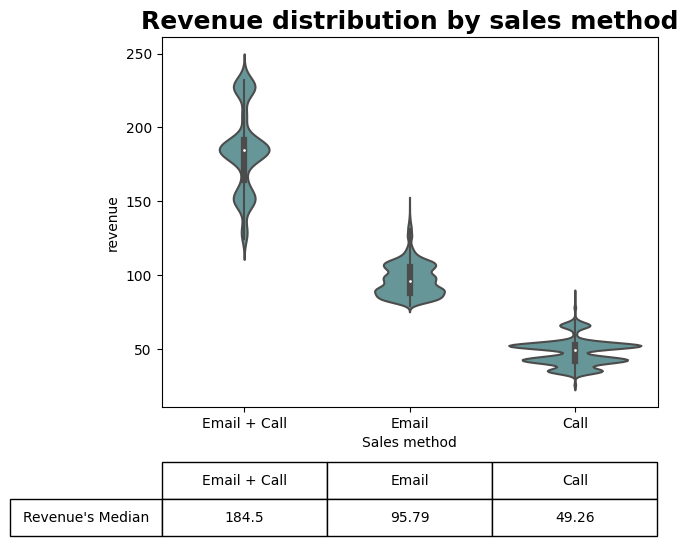

In [13]:
#@title
rev_by_method = df.groupby('sales_method')['revenue'].median().round(2).sort_values(ascending = False).to_frame()

sns.violinplot(y = 'revenue',
               x = 'sales_method',
               data = df,
               color = 'cadetblue',
               aspect = 1,
               order = rev_by_method.index)

plt.title("Revenue distribution by sales method", fontsize= 18, fontweight = 800)
plt.xlabel("Sales method")

plt.table(cellText = rev_by_method.T.values,
          rowLabels=["Revenue's Median"],
          colLabels=rev_by_method.index,
          cellLoc = 'center', rowLoc = 'center',
          loc='right', bbox=[0,-0.35,1.0,.2])

plt.show()

### 3.2.2 Revenue Distribution by Method and Week

**Was there any difference in revenue over time for each of the methods?**

It is observed that `revenue` tends to increase as the time in weeks since the product was launched increases and also grows depending on the approach, as analyzed above. It is also noted that time positively influences revenue more intensely in the ‘`Email + Call`’ method, followed by the ‘`Email`’ and ‘`Call`’ methods respectively.\
Ratifying the analysis made above and the result obtained by the ‘Forward stepwise feature selection’ method used in data imputation in the data validation stage, it is observed that the ‘`sales_method`’ feature is more important for generating revenue. It is also shown that the ‘`Email + Call`’ method is more efficient in generating revenue.\
It is also noted that the modes of the revenue distribution can be explained by the sales methods, as each method concentrates the distribution of revenues close to their respective averages.

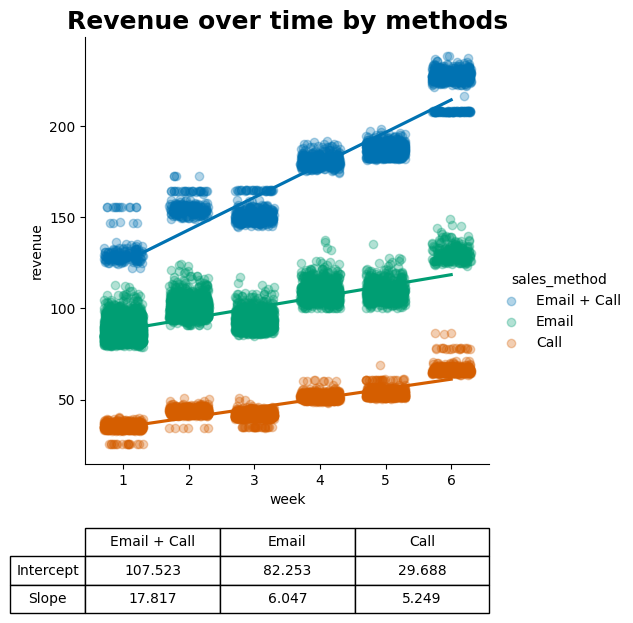

In [14]:
#@title
res = ols('revenue ~  week : sales_method + sales_method - 1', data = df).fit()

g = sns.lmplot(x = 'week',
           y = 'revenue',
           scatter_kws= {'alpha':0.3},
           hue ='sales_method',
           hue_order = rev_by_method.index,
           x_jitter=0.3,
           data = df)

axes = g.fig.axes

axes[0].table(cellText = -np.sort(-res.params.to_numpy().reshape(2,3)).round(3),
          rowLabels=['Intercept','Slope'],
          colLabels=rev_by_method.index,
          cellLoc = 'center', rowLoc = 'center',
          loc='right', bbox=[0,-0.35,1.0,.2])
plt.title("Revenue over time by methods", fontsize= 18, fontweight = 800)
plt.show()

**In the most profitable method, how does the average revenue growth percentage-wise over the weeks following a product launch?**

It is observed that this growth trend becomes more evident after the third week, as shown below.

In [15]:
#@title
rev_by_wk = df[df['sales_method'] == 'Email + Call'].groupby('week')['revenue'].mean().to_frame()
rev_by_wk.index = [f'week {k}' for k in range(1,7)]
rev_by_wk['change'] = rev_by_wk['revenue'].pct_change().fillna(0).apply('{:,.2%}'.format)
rev_by_wk.round(2).T

,week 1,week 2,week 3,week 4,week 5,week 6
revenue,131.67,155.87,151.82,181.03,187.44,224.57
change,0.00%,18.39%,-2.60%,19.24%,3.54%,19.81%


### 3.2.3 Bootstrap Hypothesis Testing

**Bootstrapping test to compare two datasets**

So far, it has been suggested that there are differences between sales methods, with ‘Email + Call’ being the most efficient, followed by ‘Email’ and finally ‘Call.’ The hypothesis that the revenues generated by these methods differ and are not due to chance, and that they follow a specific order of efficiency, will now be tested, adopting a significance level of 2.5%.

Based on observations from graph **3.2.1**, it cannot be confirmed that the different methods are identically distributed. As a result, a bootstrap hypothesis test will be employed to evaluate the hypothesis that the means of these methods are equal, without making any assumptions about their distributions.

Both analyses had p-values (p-values = 0.0) smaller than the significance level (2.5%), suggesting that the observed difference in revenues between the methods is unlikely to have occurred by chance if the null hypothesis (that the revenues generated by the two methods are equal) were true. This provides evidence in favor of the alternative hypothesis that the revenues generated by the ‘Email + Call’ method are greater than those generated by the ‘Email’ method, and that the revenues generated by the ‘Email’ method are greater than those generated by the ‘Call’ method

In [16]:
#@title
callmt = df.loc[df['sales_method'] == 'Call','revenue'].to_numpy()
emailmt = df.loc[df['sales_method'] == 'Email','revenue'].to_numpy()
em_callmt = df.loc[df['sales_method'] == 'Email + Call','revenue'].to_numpy()

mc,me,mce = list(df.groupby('sales_method')['revenue'].mean())

print("Is there evidence that the ‘Email’ method generates higher revenue than the ‘Call’ method?")
print(f"The p-value = {boots_test(emailmt,callmt)} indicates the probability that the two samples of revenues are equal.\n")


print("Is there evidence that the ‘Email + Call’ method generates higher revenue than the ‘Email’ method?")
print(f"The p-value = {boots_test(em_callmt,emailmt)} indicates the probability that the two samples of revenues are equal.")

Is there evidence that the ‘Email’ method generates higher revenue than the ‘Call’ method?
The p-value = 0.0 indicates the probability that the two samples of revenues are equal.

Is there evidence that the ‘Email + Call’ method generates higher revenue than the ‘Email’ method?
The p-value = 0.0 indicates the probability that the two samples of revenues are equal.


## 3.3 Other Outcomes.

Analysis of the other features and their relationships.

### 3.3.1 Total revenue by method

**And as for total revenue, how is it distributed in each approach?**

In terms of total revenue generated, the method with the highest financial volume is ‘Email’ with more than half of the total revenue, as it also has the highest number of customers. The second is ‘Email + Call’, even though it has the lowest number of customers, because it has the best profitability, it generates a higher total revenue than the ‘Call’ method.

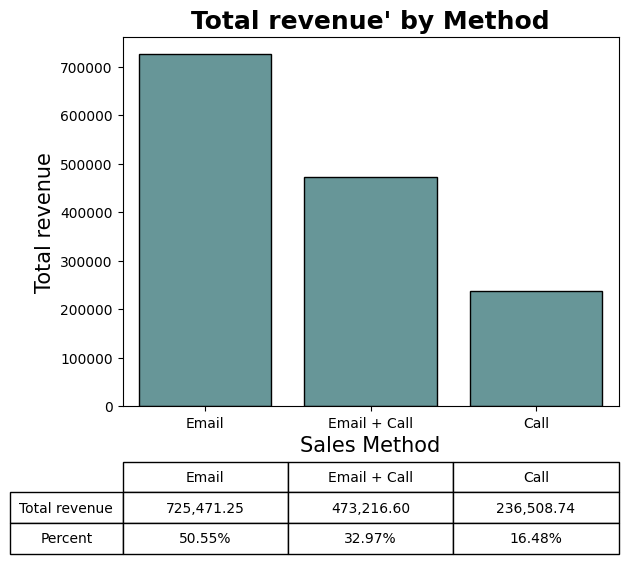

In [17]:
#@title
sumrecBymethod = df.groupby('sales_method').agg(soma = ('revenue','sum'),
                                                perc = ('revenue','sum')).sort_values(by = 'soma',
                                                                                      ascending = False)

sumrecBymethod['perc'] = (sumrecBymethod['perc'] / sumrecBymethod['perc'].sum())

mapper =  {'soma': '{0:,.2f}',
           'perc': '{0:.2%}'}

sumrecBymethod = sumrecBymethod.apply(lambda x: x.apply(mapper[x.name].format))

sns.barplot(x = 'sales_method',y = 'revenue', estimator='sum', data = df,color = 'cadetblue',
            errorbar = None,edgecolor = 'black',order = ['Email','Email + Call','Call'])


plt.table(cellText = sumrecBymethod.T.round(2).to_numpy(),
          rowLabels = ['Total revenue','Percent'],
          colLabels= sumrecBymethod.index,
          cellLoc = 'center', rowLoc = 'center',
          loc='right', bbox=[0,-0.4,1.0,.25])

plt.xlabel('Sales Method', fontsize= 15)
plt.ylabel('Total revenue', fontsize= 15)
plt.title("Total revenue' by Method", fontsize= 18, fontweight = 800)

plt.show()

### 3.3.2 **Feature Engineering**

The creation of the following features is being analyzed:

* **revenue_item**: Revenue by item -> Average price of each item

* **revenue_visit**: Revenue by nb_site_visits -> Revenue generated by each visit to the website

* **nb_sold_visit**: nb_sold by nb_site_visits -> Number of items sold on each visit

In [18]:
#@title
# Revenue by item -> Average price of each item
df['revenue_item'] = df['revenue'] / df['nb_sold']

# Revenue by nb_site_visits -> Revenue generated by each visit to the website
df['revenue_visit'] = df['revenue'] / df['nb_site_visits']

# nb_sold by nb_site_visits -> Number of items sold on each visit
df['nb_sold_visit'] = df['nb_sold'] / df['nb_site_visits']

### 3.3.3 **Features Distributions**

* The weeks with the highest number of items sold are the first few weeks after launch, probably because they have just been released and have lower launch prices
* The number of items purchased by each consumer is usually between 9 and 10 items, with a minimum of 7 and usually below 14 items.
* Half of the customers have been consumers of ‘Pens and Printers’ products for 1 to 3 years, with the vast majority having been consumers for less than 15 years.
* On average, in the last 6 months, customers have visited the ‘Pens and Printers’ website 25 times, with most customers visiting the site less than 31 times.
* The items (`revenue_item`) have prices following a trimodal distribution, probably because they represent different product lines, with prices concentrated at \$5, \$10 and \$15.
* The estimated value generated by each visit (`revenue_visit`) is around an average of $3.8, which shows the importance of the ‘nb_visits’ metric in generating revenue

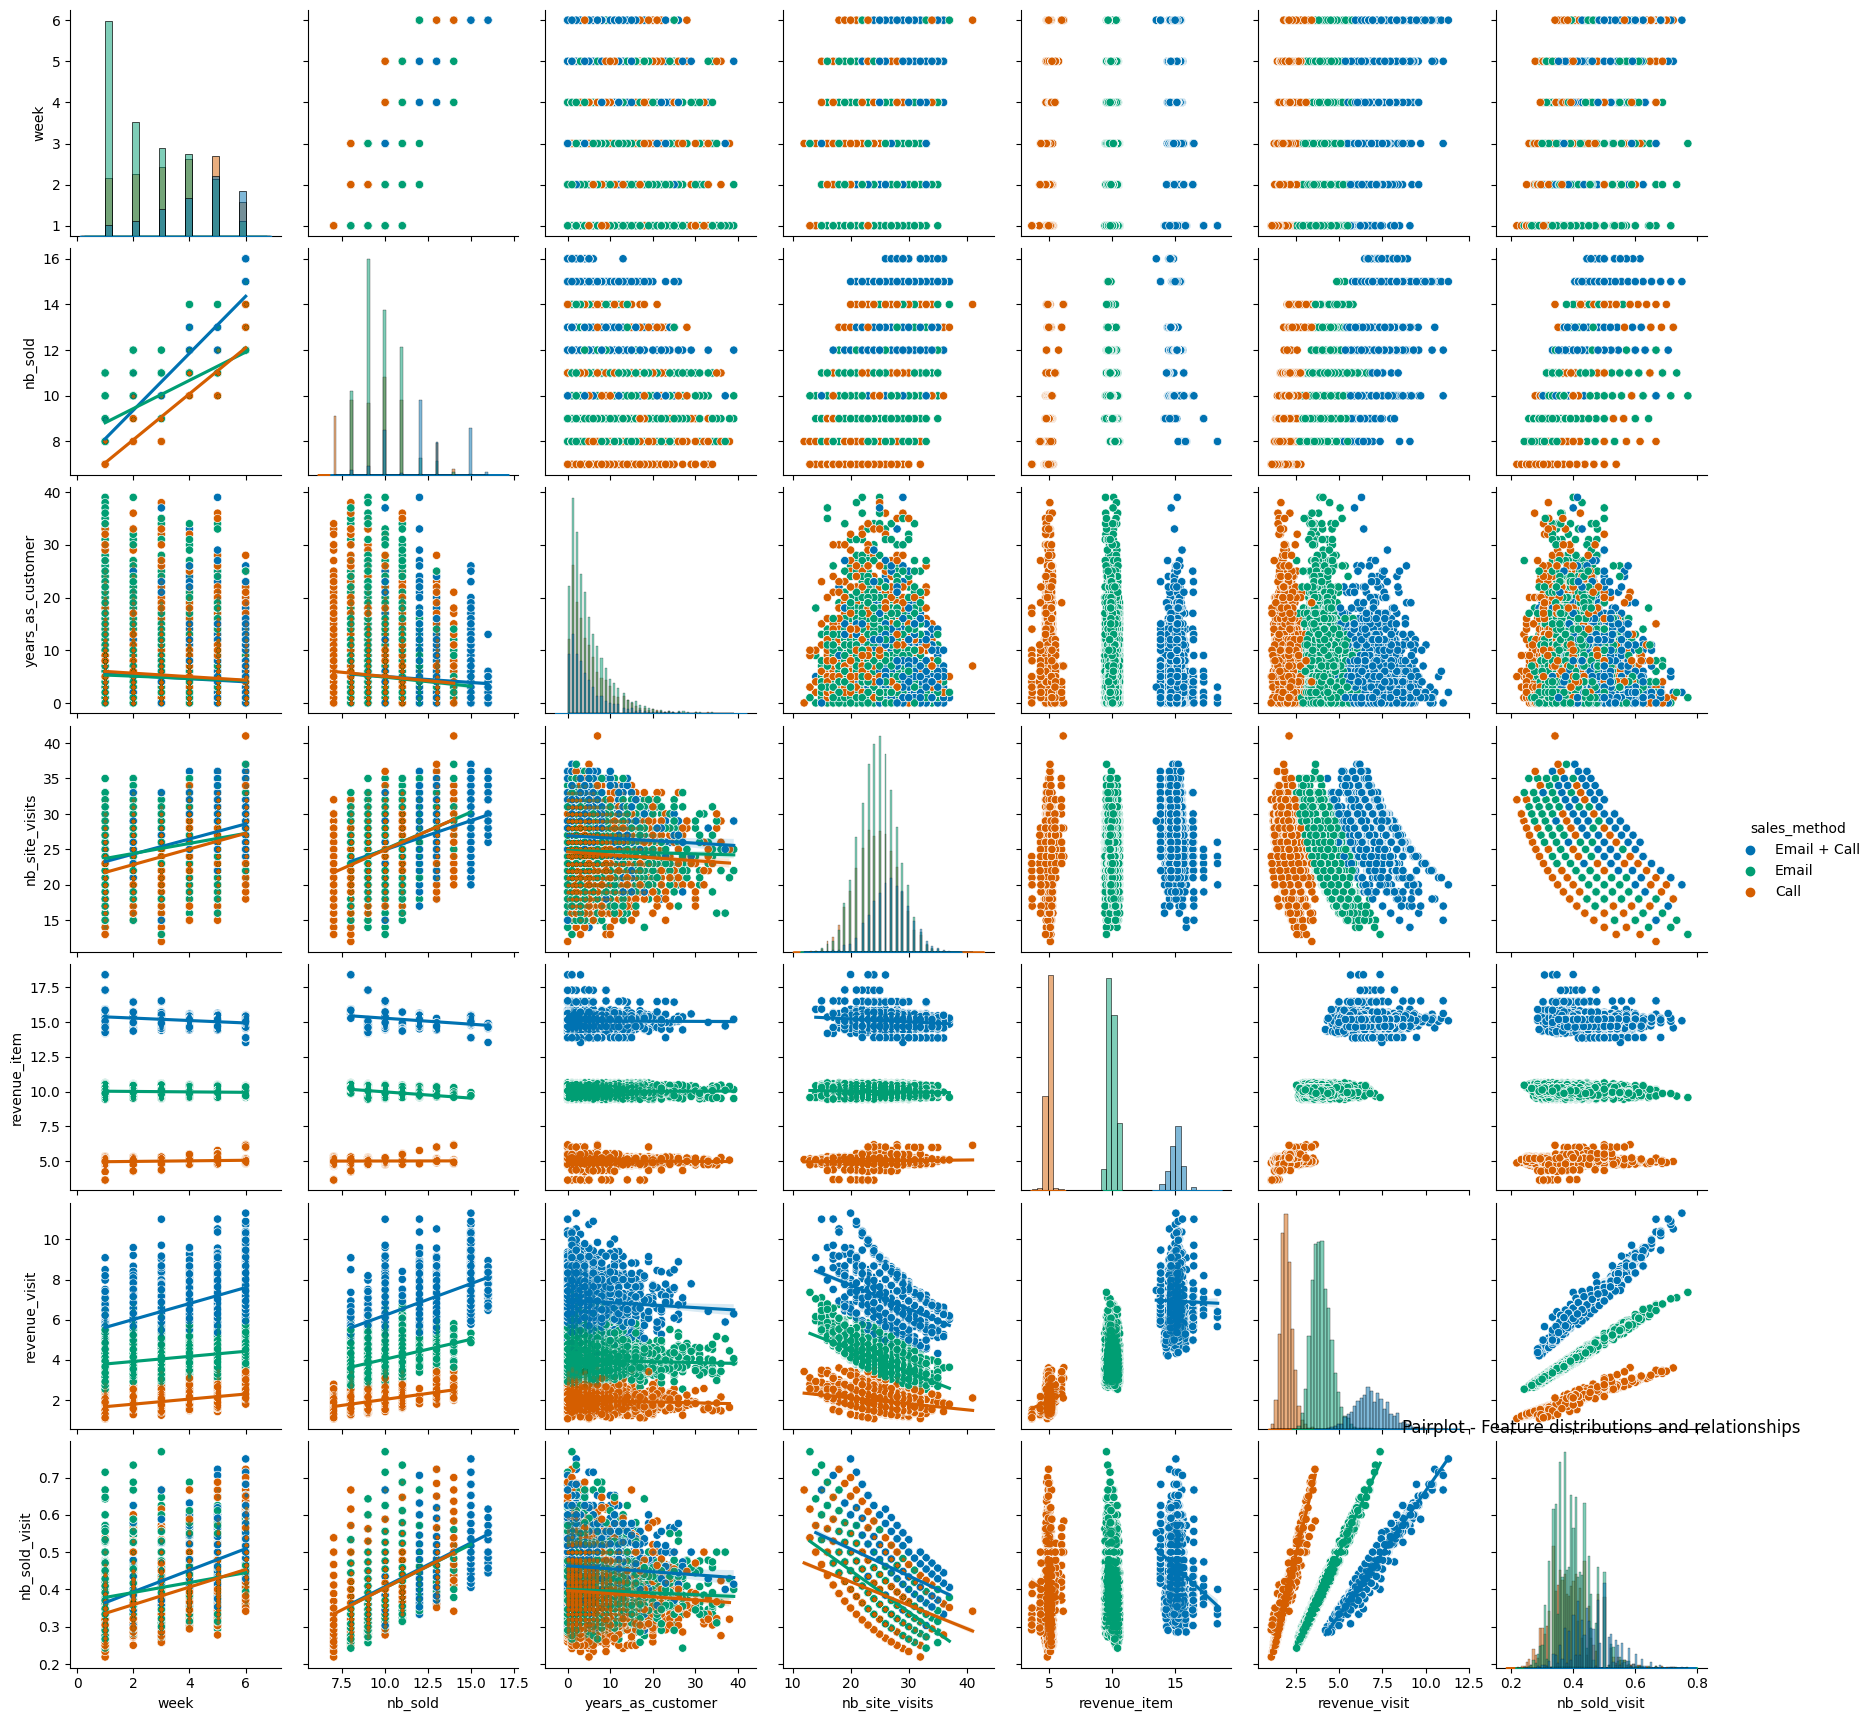

In [19]:
#@title
g = sns.pairplot(data = df,
                 vars =['week','nb_sold','years_as_customer','nb_site_visits','revenue_item','revenue_visit','nb_sold_visit'],
                 hue = 'sales_method',
                hue_order= ['Email + Call','Email','Call'])
g.map_lower(sns.regplot,scatter_kws = {'alpha': 0.1,'s':3})
g.map_diag(sns.histplot)
plt.title("Pairplot - Feature distributions and relationships")
plt.show()

### 3.3.4 Feature’s relationships

**Analysis of the feature’s relationships**

For this analysis, preprocessing was done using one-hot encoding on the categorical variables to analyze the relationships between them and the other numerical features.\
Only variables with an absolute correlation value greater than 0.3 will be analyzed.

* The **‘`nb_site_visits`’** feature has a reasonable correlation with ‘`revenue`’ and ‘`nb_sold`’, indicating that the website is important for these metrics.
* The **`years_as_customer`** feature has a very low correlation with revenue, and this correlation is negative.

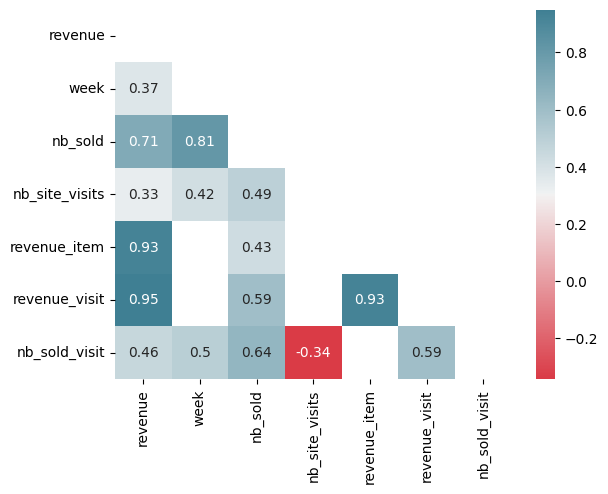

In [20]:
#@title
df_rev =df[['revenue','week','nb_sold','years_as_customer','nb_site_visits',
            'revenue_item','revenue_visit','nb_sold_visit']].dropna()

df_rev = pd.get_dummies(df_rev)

cor = df_rev.corr()

cor = cor[np.abs(cor) > 0.3]

cor_na = cor.isna().sum()

cor = cor[cor_na != 7].T[cor_na != 7]

matrix = np.triu(cor)

# Define a custom palette
color_palette = sns.diverging_palette(10, 220, as_cmap = True)

sns.heatmap(cor, annot=True, mask = matrix, cmap = color_palette)
plt.show()

### 3.3.5 State Analysis

**How is the quantity of purchases distributed among the states?**

Of the 50 states, 22 (44%) represent more than 80% of new product consumers. Among these, California and Texas have the highest number of consumers.

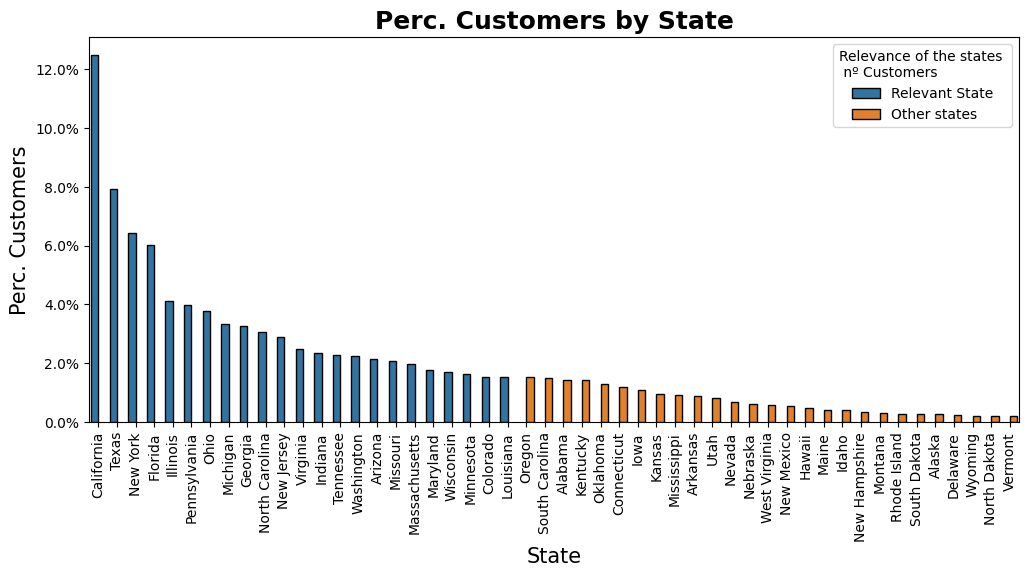

In [21]:
#@title
cust_state = df['state'].value_counts(normalize=True).to_frame().rename(columns = {'state':'State_Custome_Pct'})

cust_state.sort_values(
    by = 'State_Custome_Pct',
    inplace=True,ascending = False)


cust_state['acum'] = cust_state['State_Custome_Pct'].cumsum()
cust_state['pareto'] = np.where(cust_state['acum'] < 0.81,'Relevant State','Other states')

# Ploting
fig,ax = plt.subplots(figsize= (12,5))

sns.barplot(x =cust_state.index,
            y='State_Custome_Pct',
            hue = 'pareto',
            edgecolor = 'black',
            palette = sns.color_palette("tab10"),
            data = cust_state)

ax.set_xlabel('State', fontsize= 15)
ax.set_ylabel('Perc. Customers', fontsize= 15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_title("Perc. Customers by State", fontsize= 18, fontweight = 800)
plt.legend(title = 'Relevance of the states \n nº Customers',
           loc = 'upper right')
plt.xticks(rotation=90)
plt.show()

**Which state represents the biggest source of revenue for 'Pens and Printers'?**

As expected, the states of California and Texas are the most relevant in terms of generating revenue from new products.\
As in the previous analysis, 22 (44%) of the states represent more than 80% of the total revenue from new products.

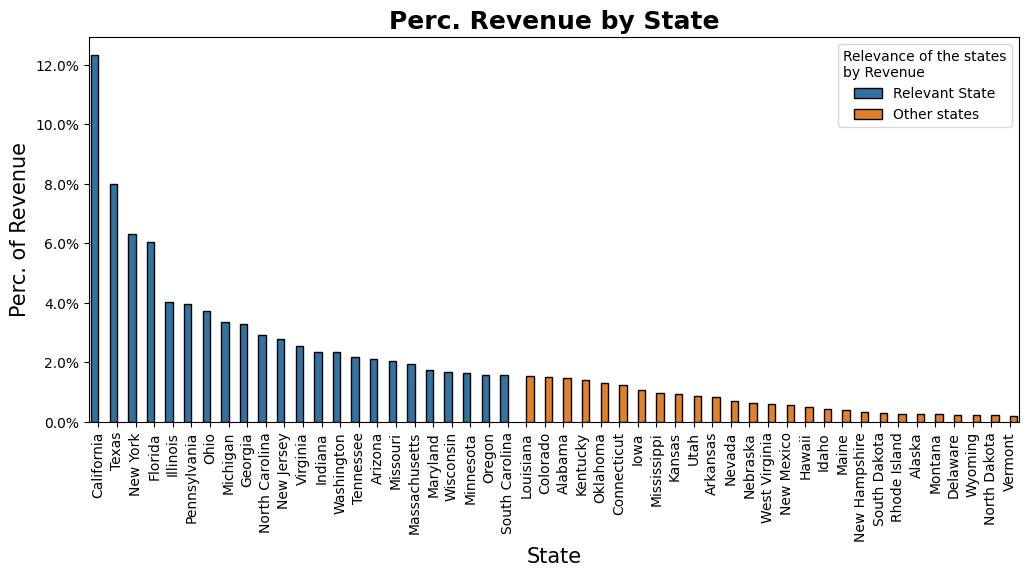

In [22]:
#@title
rev_state = df.groupby('state').agg(
    total_revenue = ('revenue','sum'),
    mean_revenue = ('revenue','mean')).sort_values(by = 'total_revenue',
                                                   ascending=False).reset_index()

rev_state['State_rev_pct'] = (rev_state['total_revenue'] / rev_state['total_revenue'].sum())
rev_state['acum'] = rev_state['State_rev_pct'].cumsum()
rev_state['pareto'] = np.where(rev_state['acum'] < 0.81,'Relevant State','Other states')

# Ploting
fig,ax = plt.subplots(figsize= (12,5))

sns.barplot(x ='state',
            y='State_rev_pct',
            hue = 'pareto',
            edgecolor = 'black',
            palette = sns.color_palette("tab10"),
            data = rev_state)

ax.set_xlabel('State', fontsize= 15)
ax.set_ylabel('Perc. of Revenue', fontsize= 15)
ax.set_title("Perc. Revenue by State", fontsize= 18, fontweight = 800)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.legend(title = 'Relevance of the states\nby Revenue', loc = 'upper right')
plt.xticks(rotation=90)
plt.show()

**Is there a difference in average income between each state?**

The average revenue per state does not vary much, being on median close to \$ 96, with 'South Dakota' and 'Vermont' being the states with the highest average. The states with the highest volume of revenue, which are California and Texas, have an average revenue of \$ 94.55 and \$96.54 respectively.

In [23]:
#@title
rev_state.sort_values(by = 'mean_revenue',
                     ascending=False,
                     inplace=True)

display(rev_state[['mean_revenue']].describe().T.round(3))

,count,mean,std,min,25%,50%,75%,max
mean_revenue,50.0,96.78,4.243,83.909,94.453,96.27,99.469,106.084


**What justifies the difference in total revenue among states? Is there any state that should be focused on?**

When comparing the population of each state, a high correlation (**0.99** - Extremely Strong Correlation) is observed between the population of each state and its total revenue. This may indicate a good distribution of revenue among the populations of each state. In other words, the large volume of revenues from states such as California and Texas is likely due to these states being the most populous.

**Geographical distribution of revenue sources**

Below is a geospatial representation of the distribution of revenues. As it is well distributed in the states in relation to the population, the distribution of revenues resembles the demographic density.

Correlation between the population of each state and total revenue = 0.9963


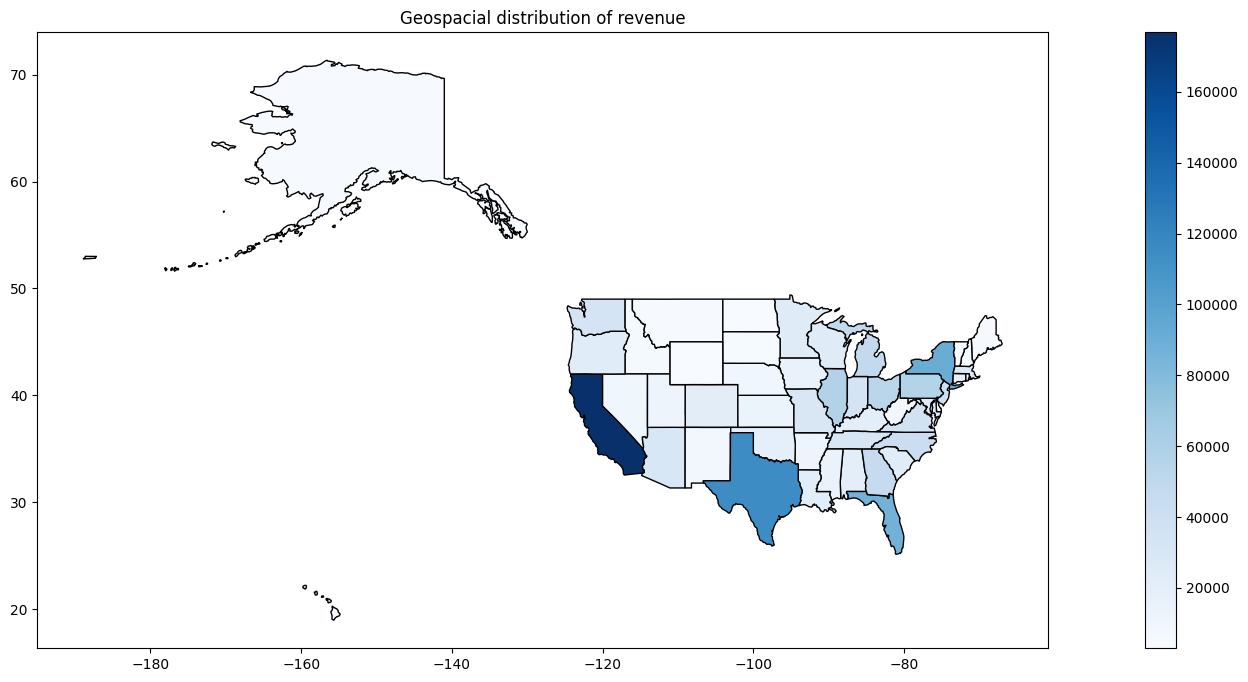

In [24]:
#@title
# Merge population to revenue dataframe

rev_state = rev_state.merge(dfpop)

cor_rev_pop = rev_state[['total_revenue','population']].corr().iloc[0,1]
print(f'Correlation between the population of each state and total revenue = {cor_rev_pop:.4f}')

fig,ax = plt.subplots(figsize = (25, 8))
dfgeo.merge(rev_state, right_on = 'state',
            left_on = 'name').plot(column = 'total_revenue',
                                   legend=True,
                                   cmap='Blues',
                                   edgecolor='k',
                                   ax = ax);
plt.title('Geospacial distribution of revenue')
plt.show()

### 3.3.6 Customer Segmentation

**Which consumer groups have the highest volume of purchases?**

It is observed that 20% of consumers are responsible for about 40% of total revenue, 40% are responsible for 60%, and 60% are responsible for about 80%. This gives us a good indication of which consumers may have more potential for generating revenue.

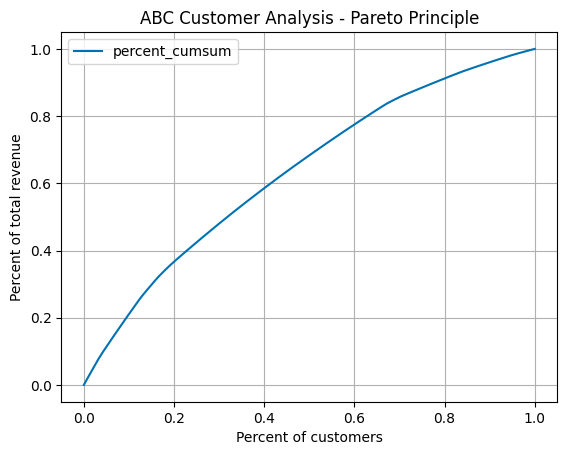

In [25]:
#@title
topcons = df[['revenue']].sort_values(by = 'revenue', ascending = False)
topcons['percent_cumsum'] = topcons['revenue'].cumsum() / topcons['revenue'].sum()
topcons['percent_cont'] = np.arange(1,len(df)+1) / len(df)
topcons.plot(x = 'percent_cont', y = 'percent_cumsum',kind = 'line', grid = True)
plt.xlabel('Percent of customers')
plt.ylabel('Percent of total revenue')
plt.title('ABC Customer Analysis - Pareto Principle')
plt.show()

# 4. Discussion and Results

## 4.1 Based on the data, which method is recommended for continued use?

* As stated in sections **2.6 and 3.2.2**, the recommended approach for continued use is the ‘`Call+Email`’ method, as it generates the highest revenue in both average and marginal terms, because there is a trend of increasing revenue each week following the launch.
* As verified in item **2. Data validation** , this method has a much lower team time demand (‘`Call+Email`’:**10min**) than the **`call`(30min)** method , even though it has a higher time demand than the ‘`Email`’(**Very little work**) method, it becomes preferable due to its  efficiency in generating revenue. Nonetheless, it is recommended to evaluate all costs associated with each sales process. This allows for an accurate measurement of the potential profit generated from the increase in revenue.

## 4.2 Business Metrics

* As the main goal of any business is to generate profit, and this is usually related to '`revenue`', it is recommended to analyze this metric as a measure of business success.
* Another metric that also requires attention is the **number of website visits in the last 6 months**, as this can also increase revenue.

## 4.3 Initial metric

**Initial values for the metric, based on current data**

Based on the last 6 months of observation, the current average revenue is approximately **\$ 95.70** per sale. With the adoption of prioritizing the ‘`Email + Call`’ method, it is expected that this value will increase in the next 6 months, which may indicate a positive sign that the reallocation of the sales approach is yielding results

# 5. Recommendation

For the following weeks, I would recommend we can focus on the following steps:

* Gradually shift the team’s efforts from the ‘`Call`’ and ‘`Email`’ methods to the ‘`Call+Email`’ method and continuously verify the impact of this change, checking if it will actually generate an increase in revenue/profit.


* **To implement this strategy, it is proposed**:
    *  Allocate resources strategically and increase effort progressively for the `Call + Email` method, particularly after the third week. After this week, the average forecast for revenue growth is about 14% per week (as seen in the table in **item 3.2.2**). A gradual approach is necessary due to the potential for varying efficiency of each method for different products.
    *  After sending the Email, to make the process more efficient, choose the customers to whom the calls will be made, emphasizing those who may have the greatest potential for revenue, using a segmentation like the one shown in **item 3.3.6**.


* **Suggestions for Enhancing Data Collection**.
    * Improve data quality by mitigating missing data and understand which customers are outliers to understand the reason for errors in time as a consumer.
    * Provide cost data for each sales approach so that profit can be better estimated, as it is a more important metric than revenue.
    * Provide information about the conversion rate of each method, as this will allow for a better understanding of the effort vs. result relationship for each approach.
    * Insert recency and frequency data for an RFM analysis and indication of customers with more potential to acquire new products.
    * Indicate the types of products sold by each method to determine which method may yield better results for a particular type of product.
    * Conduct surveys with customers to better understand their perceptions and opinions about the different sales methods, and use this information to improve sales strategies.